In [72]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.
# import kagglehub
# crawford_vgg16_path = kagglehub.dataset_download('crawford/vgg16')
# alxmamaev_flowers_recognition_path = kagglehub.dataset_download('alxmamaev/flowers-recognition')
# print(alxmamaev_flowers_recognition_path)
# print('Data source import complete.')


# VGGNet Complete Architecture

### This notebook is a part of state-of-the-art Deep Learning Models Discussion.<br> This is third notebook in the series.<br>
> Visit here: [SOTA Papers Discussion](https://www.kaggle.com/general/166349)<br>
> Sample data used for demo: [Dataset](https://www.kaggle.com/alxmamaev/flowers-recognition)<br>
> Read my other notebooks: [Notebooks](https://www.kaggle.com/blurredmachine/notebooks)<br>
> SOTA Model Notebooks have been released earlier. [View previous notebooks](https://www.kaggle.com/general/166349)<br>

![VGGNet](https://www.researchgate.net/publication/335353308/figure/fig2/AS:795069422522368@1566570730026/The-architecture-of-the-beamforming-deep-neural-network.ppm)

## Introduction on VGGNet
The full name of VGG is the **Visual Geometry Group**, which belongs to the Department of Science and Engineering of Oxford University. It has released a series of convolutional network models beginning with VGG, which can be applied to face recognition and image classification, from VGG16 to VGG19. The original purpose of VGG's research on the depth of convolutional networks is to understand how the depth of convolutional networks affects the accuracy and accuracy of large-scale image classification and recognition. -Deep-16 CNN), in order to deepen the number of network layers and to avoid too many parameters, a small 3x3 convolution kernel is used in all layers.

<a href="http://ethereon.github.io/netscope/#/gist/dc5003de6943ea5a6b8b" target="_blank">Network Structure of VGG19</a>

## The network structure
- The input of VGG is set to an RGB image of 224x244 size. The average RGB value is calculated for all images on the training set image, and then the image is input as an input to the VGG convolution network. A 3x3 or 1x1 filter is used, and the convolution step is fixed. . There are 3 VGG fully connected layers, which can vary from VGG11 to VGG19 according to the total number of convolutional layers + fully connected layers. The minimum VGG11 has 8 convolutional layers and 3 fully connected layers. The maximum VGG19 has 16 convolutional layers. +3 fully connected layers. In addition, the VGG network is not followed by a pooling layer behind each convolutional layer, or a total of 5 pooling layers distributed under different convolutional layers. The following figure is VGG Structure diagram:


![title](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/vgg.png)

![config](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/network.png)

- VGG16 contains 16 layers and VGG19 contains 19 layers. A series of VGGs are exactly the same in the last three fully connected layers. The overall structure includes 5 sets of convolutional layers, followed by a MaxPool. The difference is that more and more cascaded convolutional layers are included in the five sets of convolutional layers .

![config](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/config2.jpg)


- Each convolutional layer in AlexNet contains only one convolution, and the size of the convolution kernel is 7 * 7 ,. In VGGNet, each convolution layer contains 2 to 4 convolution operations. The size of the convolution kernel is 3 * 3, the convolution step size is 1, the pooling kernel is 2 * 2, and the step size is 2. The most obvious improvement of VGGNet is to reduce the size of the convolution kernel and increase the number of convolution layers.


![config](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/config3.jpg)


- Using multiple convolution layers with smaller convolution kernels instead of a larger convolution layer with convolution kernels can reduce parameters on the one hand, and the author believes that it is equivalent to more non-linear mapping, which increases the Fit expression ability.

![config](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/config4.png)

- Two consecutive 3 * 3 convolutions are equivalent to a 5 * 5 receptive field, and three are equivalent to 7 * 7. The advantages of using three 3 * 3 convolutions instead of one 7 * 7 convolution are twofold : one, including three ReLu layers instead of one , makes the decision function more discriminative; and two, reducing parameters . For example, the input and output are all C channels. 3 convolutional layers using 3 * 3 require 3 (3 * 3 * C * C) = 27 * C * C, and 1 convolutional layer using 7 * 7 requires 7 * 7 * C * C = 49C * C. This can be seen as applying a kind of regularization to the 7 * 7 convolution, so that it is decomposed into three 3 * 3 convolutions.

- The 1 * 1 convolution layer is mainly to increase the non-linearity of the decision function without affecting the receptive field of the convolution layer. Although the 1 * 1 convolution operation is linear, ReLu adds non-linearity.

## Network Configuration

- Table 1 shows all network configurations. These networks follow the same design principles, but differ in depth.

![config](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/netconvgg.png)

- This picture is definitely used when introducing VGG16. This picture contains a lot of information. My interpretation here may be limited. If you have any supplements, please leave a message.

* **Number 1** : This is a comparison chart of 6 networks. From A to E, the network is getting deeper. Several layers have been added to verify the effect.

* **Number 2** : Each column explains the structure of each network in detail.

* **Number 3**: This is a correct way to do experiments, that is, use the simplest method to solve the problem , and then gradually optimize for the problems that occur.

**Network A**: First mention a shallow network, this network can easily converge on ImageNet.
And then?<br>
**Network A-LRN**: Add something that someone else (AlexNet) has experimented to say is effective (LRN), but it seems useless.
And then?<br>
**Network B**: Then try adding 2 layers? Seems to be effective.
And then?<br>
**Network C**: Add two more layers of 1 * 1 convolution, and it will definitely converge. The effect seems to be better. A little excited.
And then?<br>
**Network D**: Change the 1 * 1 convolution kernel to 3 * 3. Try it. The effect has improved again. Seems to be the best (2014).

## Training

- **The optimization method** is a stochastic gradient descent SGD + momentum (0.9) with momentum.
The batch size is 256.

- **Regularization** : L2 regularization is used, and the weight decay is 5e-4. Dropout is after the first two fully connected layers, p = 0.5.

- Although it is deeper and has more parameters than the AlexNet network, we speculate that VGGNet can converge in less cycles for two reasons: one, the greater depth and smaller convolutions bring implicit regularization ; Second, some layers of pre-training.

- **Parameter initialization** : For a shallow A network, parameters are randomly initialized, the weight w is sampled from N (0, 0.01), and the bias is initialized to 0. Then, for deeper networks, first the first four convolutional layers and three fully connected layers are initialized with the parameters of the A network. However, it was later discovered that it is also possible to directly initialize it without using pre-trained parameters.

- In order to obtain a 224 * 224 input image, each rescaled image is randomly cropped in each SGD iteration. In order to enhance the data set, the cropped image is also randomly flipped horizontally and RGB color shifted.



## Summary of VGGNet improvement points

1. A smaller 3 * 3 convolution kernel and a deeper network are used . The stack of two 3 * 3 convolution kernels is relative to the field of view of a 5 * 5 convolution kernel, and the stack of three 3 * 3 convolution kernels is equivalent to the field of view of a 7 * 7 convolution kernel. In this way, there can be fewer parameters (3 stacked 3 * 3 structures have only 7 * 7 structural parameters (3 * 3 * 3) / (7 * 7) = 55%); on the other hand, they have more The non-linear transformation increases the ability of CNN to learn features.

2. In the convolutional structure of VGGNet, a 1 * 1 convolution kernel is introduced. Without affecting the input and output dimensions, non-linear transformation is introduced to increase the expressive power of the network and reduce the amount of calculation.

3. During training, first train a simple (low-level) VGGNet A-level network, and then use the weights of the A network to initialize the complex models that follow to speed up the convergence of training .


## Some basic FAQs

**Q1: Why can 3 3x3 convolutions replace 7x7 convolutions?**

***Answer 1***<br>
3 3x3 convolutions, using 3 non-linear activation functions, increasing non-linear expression capabilities, making the segmentation plane more separable
Reduce the number of parameters. For the convolution kernel of C channels, 7x7 contains parameters , and the number of 3 3x3 parameters is greatly reduced.


**Q2: The role of 1x1 convolution kernel**

***Answer 2***<br>
Increase the nonlinearity of the model without affecting the receptive field
1x1 winding machine is equivalent to linear transformation, and the non-linear activation function plays a non-linear role


**Q3: The effect of network depth on results (in the same year, Google also independently released the network GoogleNet with a depth of 22 layers)**

***Answer 3***<br>
VGG and GoogleNet models are deep
Small convolution
VGG only uses 3x3, while GoogleNet uses 1x1, 3x3, 5x5, the model is more complicated (the model began to use a large convolution kernel to reduce the calculation of the subsequent machine layer)


## VGG-16 Code Implementation

### Importing Libraries

In [73]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

### Defining input image shape

In [74]:
_input = Input((224,224,1))

### Building a VGG-16 model

In [75]:
conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(1000, activation="softmax")(dense2)

vgg16_model  = Model(inputs=_input, outputs=output)

### Working with pretrained model

- Keras library also provides the pre-trained model in which one can load the saved model weights, and use them for different purposes : transfer learning, image feature extraction, and object detection. We can load the model architecture given in the library, and then add all the weights to the respective layers.

- Before using the pretrained models, lets write a few functions which will be used to make some predictions. First, load some images and preprocess them.

In [76]:
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import os

img1 = "/Users/tansylu/Documents/kagglehub/datasets/alxmamaev/flowers-recognition/flowers/dandelion/10477378514_9ffbcec4cf_m.jpg"
img2 = "/Users/tansylu/Documents/kagglehub/datasets/alxmamaev/flowers-recognition/flowers/dandelion/10477378514_9ffbcec4cf_m.jpg"

imgs = [img1, img2, ]

def _load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def _get_predictions(_model):
    f, ax = plt.subplots(1, 2)
    f.set_size_inches(80, 40)
    for i in range(2):
        ax[i].imshow(Image.open(imgs[i]).resize((200, 200), Image.LANCZOS))
    plt.show()

    f, axes = plt.subplots(1, 2)
    f.set_size_inches(80, 20)
    for i,img_path in enumerate(imgs):
        img = _load_image(img_path)
        preds  = decode_predictions(_model.predict(img), top=3)[0]
        b = sns.barplot(y=[c[1] for c in preds], x=[c[2] for c in preds], color="gray", ax=axes[i])
        b.tick_params(labelsize=55)
        f.tight_layout()

### Using pretrained weights to save some time.

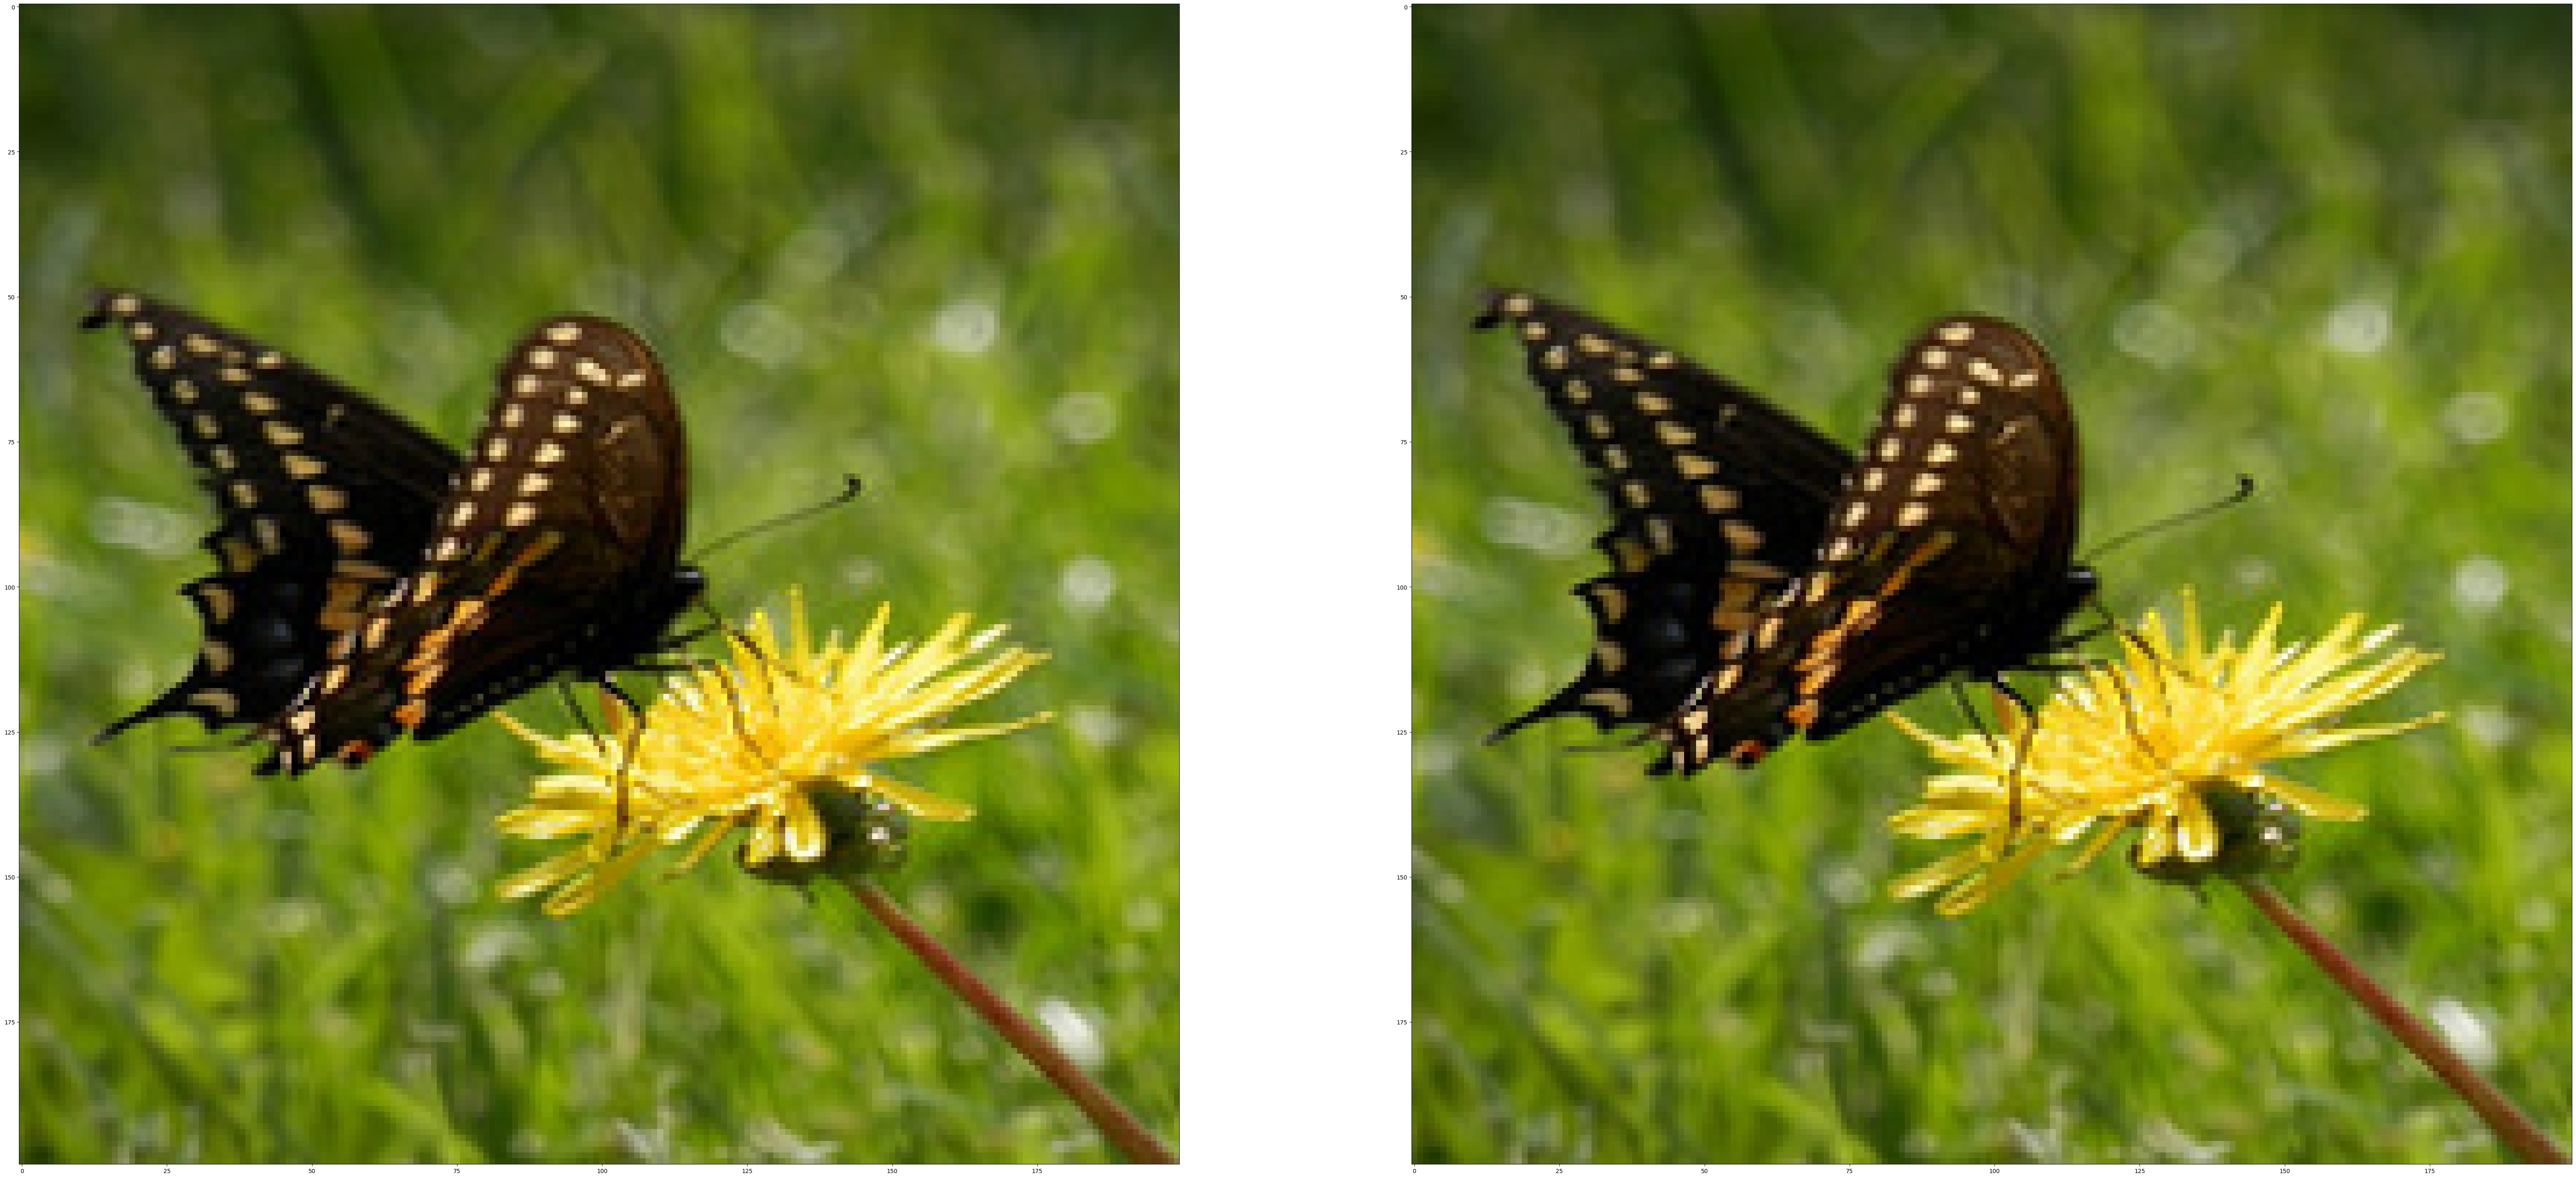

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


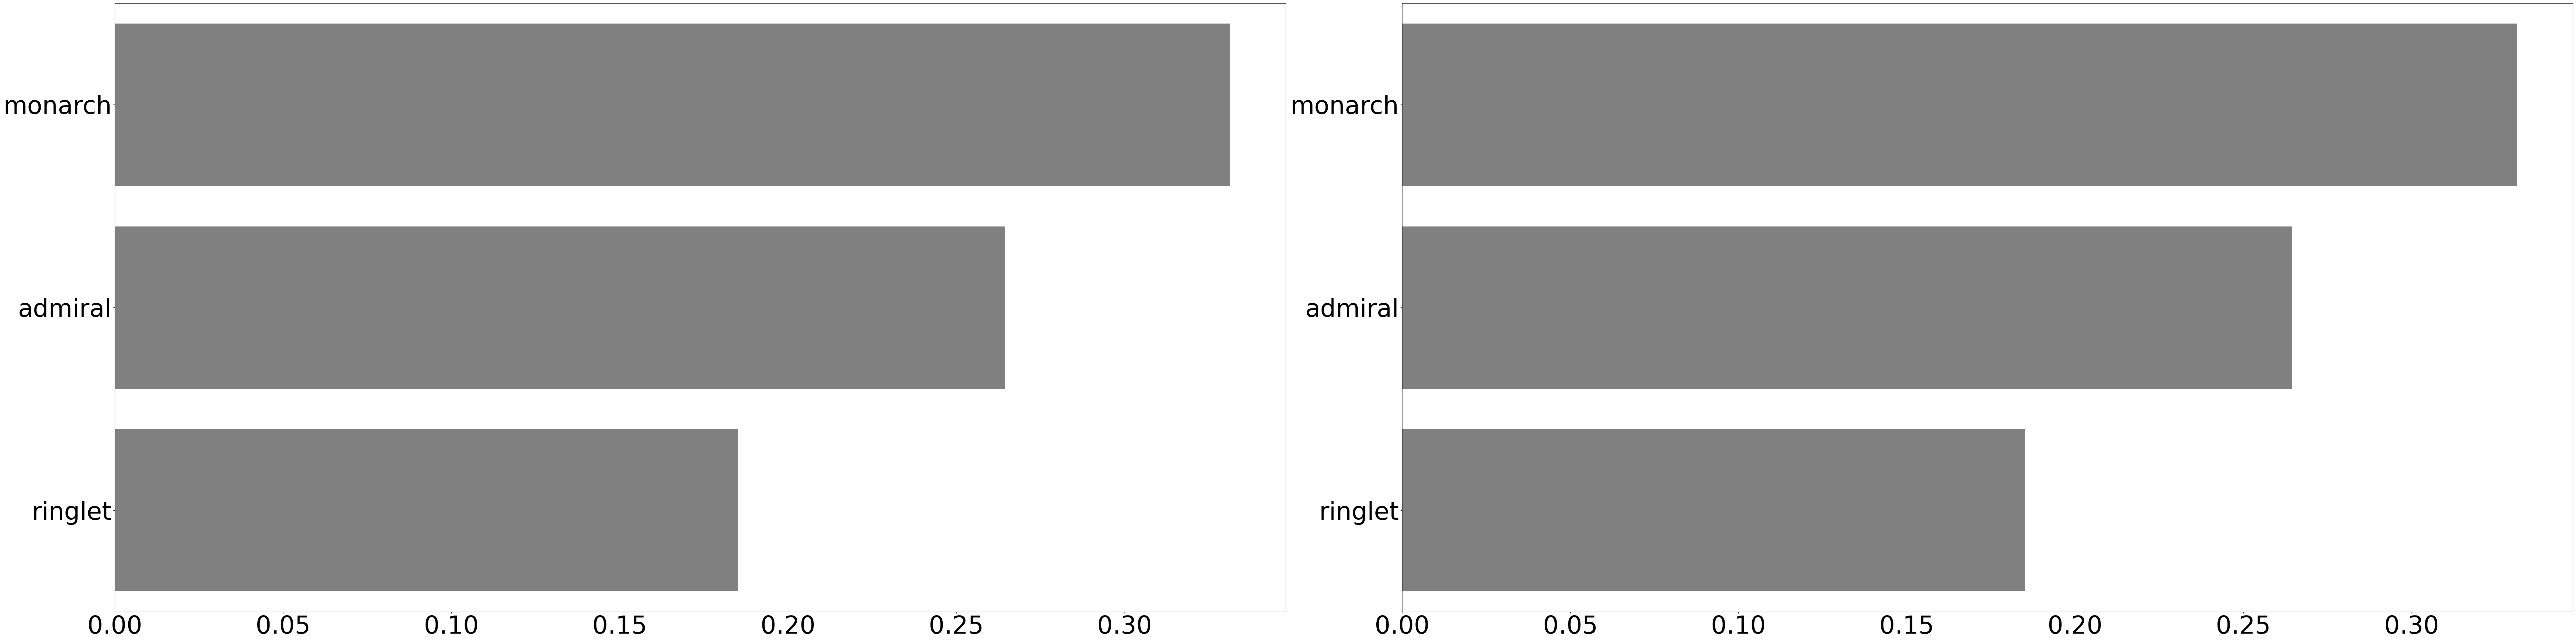

In [77]:
from keras.applications.vgg16 import VGG16
vgg16_weights = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
vgg16_model = VGG16(weights=vgg16_weights)
_get_predictions(vgg16_model)

## I hope you enjoyed reading it :)<br>Give this notebook a thumbs up if you like it.

### <a href="https://www.kaggle.com/general/166349">Read the complete series of SOTA Deep Learning Model Architectures here! </a>